In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
path = '/content/drive/MyDrive/DSA3101_Share/'

In [3]:
df = pd.read_csv(path+'2006_to_2008_preprocessed.csv')

In [4]:
df.drop(['solarradiation','solarenergy','uvindex','severerisk','sunrise','sunset'], axis=1, inplace=True)
df.drop(['precipprob','preciptype','icon'],axis=1, inplace=True)

In [5]:
for col in df.select_dtypes(include=['object']):
    df[col] = df[col].astype('category')

# Replace missing categorical (factor) values with 'unknown'
for col in df.select_dtypes(include=['category']):
    df[col] = df[col].cat.add_categories(['unknown'])
    df[col].fillna('unknown', inplace=True)

# Replace missing numeric values with mean of that column
for col in df.select_dtypes(include=[np.number]):
    mean_val = df[col].mean()
    df[col].fillna(mean_val, inplace=True)

In [9]:
df.dtypes

Year                    int64
Month                   int64
DayofMonth              int64
DayOfWeek               int64
CRSDepTime              int64
CRSArrTime              int64
UniqueCarrier        category
TailNum              category
CRSElapsedTime        float64
Origin               category
Dest                 category
Distance                int64
origin_state         category
tempmax               float64
tempmin               float64
temp                  float64
feelslikemax          float64
feelslikemin          float64
feelslike             float64
dew                   float64
humidity              float64
precip                float64
precipcover           float64
snow                  float64
snowdepth             float64
windgust              float64
windspeed             float64
winddir               float64
sealevelpressure      float64
cloudcover            float64
visibility            float64
moonphase             float64
conditions           category
descriptio

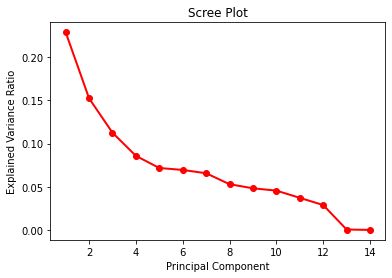

In [8]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
weather_df = df[['temp', 'feelslike', 'dew', 'humidity', 'precip', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]
weather_df = (weather_df - weather_df.mean()) / weather_df.std()
pca = PCA()
weather_pca = pca.fit_transform(weather_df)
plt.plot(range(1, pca.n_components_+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [10]:
import statsmodels.api as sm

pca = PCA(n_components=6)
weather_pca = pca.fit_transform(weather_df)
df['Weather_PC1'] = weather_pca[:, 0]
df['Weather_PC2'] = weather_pca[:, 1]
df['Weather_PC3'] = weather_pca[:, 2]
df['Weather_PC4'] = weather_pca[:, 3]
df['Weather_PC5'] = weather_pca[:, 4]
df['Weather_PC6'] = weather_pca[:, 5]

ValueError: ignored

In [13]:
date_str = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2) + '-' + df['DayofMonth'].astype(str).str.zfill(2)
daily_df = df[['Arr_Delay_boolean', 'Weather_PC1', 'Weather_PC2', 'Weather_PC3', 'Weather_PC4', 'Weather_PC5', 'Weather_PC6']].groupby(pd.to_datetime(date_str, format='%Y-%m-%d')).mean()
model = sm.tsa.statespace.SARIMAX(daily_df['Arr_Delay_boolean'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), exog=daily_df[['Weather_PC1', 'Weather_PC2', 'Weather_PC3', 'Weather_PC4', 'Weather_PC5', 'Weather_PC6']], trend='c')
results = model.fit()
print(results.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                 Arr_Delay_boolean   No. Observations:                  851
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                1195.432
Date:                           Wed, 29 Mar 2023   AIC                          -2366.863
Time:                                   06:37:33   BIC                          -2309.906
Sample:                               01-01-2006   HQIC                         -2345.047
                                    - 04-30-2008                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0014      0.001      1.664      0.096      -0.000       0.003
Weather_PC1     0.0048      0.004      1

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
forecast = results.get_forecast(steps=7, exog=daily_df[['Weather_PC1', 'Weather_PC2', 'Weather_PC3', 'Weather_PC4', 'Weather_PC5', 'Weather_PC6']].tail(7))
forecast_summary = forecast.summary_frame()

print(forecast_summary)

Arr_Delay_boolean      mean   mean_se  mean_ci_lower  mean_ci_upper
2008-05-01         0.419290  0.058305       0.305014       0.533567
2008-05-02         0.487253  0.066271       0.357364       0.617141
2008-05-03         0.393528  0.068680       0.258919       0.528138
2008-05-04         0.470876  0.069450       0.334755       0.606996
2008-05-05         0.481144  0.069701       0.344532       0.617756
2008-05-06         0.405907  0.069783       0.269135       0.542680
2008-05-07         0.379212  0.069810       0.242388       0.516037


In [15]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Get the actual values
y_true = daily_df['Arr_Delay_boolean'].tail(7)

# Get the predicted values
y_pred = forecast_summary['mean'].values

# Calculate the MAPE and RMSE
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f'MAPE: {mape:.2%}')
print(f'RMSE: {rmse:.2f}')


MAPE: 11.11%
RMSE: 0.05


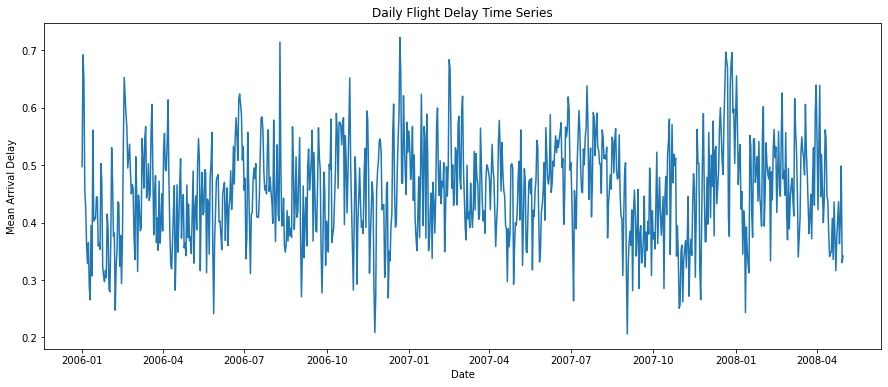

In [23]:
import matplotlib.pyplot as plt

# plot time series
plt.figure(figsize=(15, 6))
plt.plot(daily_df.index, daily_df['Arr_Delay_boolean'])
plt.title('Daily Flight Delay Time Series')
plt.xlabel('Date')
plt.ylabel('Mean Arrival Delay')
plt.show()


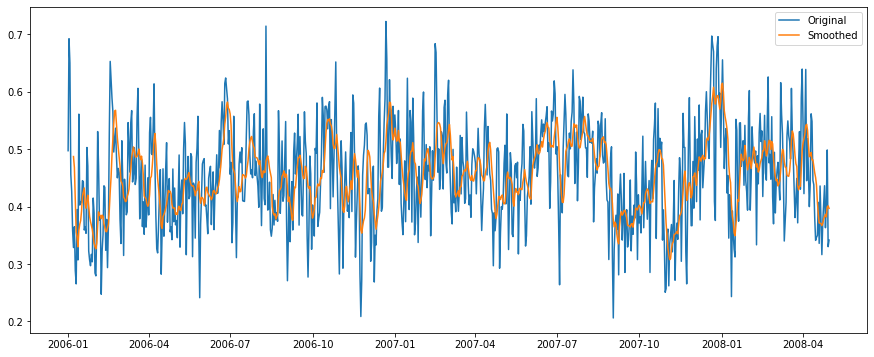

In [26]:
import matplotlib.pyplot as plt

# Smoothed curve with a rolling window of size 7
rolling_mean = daily_df['Arr_Delay_boolean'].rolling(window=7).mean()

# Plot original data and smoothed curve
plt.figure(figsize=(15, 6))
plt.plot(daily_df.index, daily_df['Arr_Delay_boolean'], label='Original')
plt.plot(daily_df.index, rolling_mean, label='Smoothed')
plt.legend()
plt.show()


In [28]:
# Split the data into training and test sets
train_df = daily_df[:-100]
test_df = daily_df[-100:]

# Fit the SARIMAX model on the training set
model = sm.tsa.statespace.SARIMAX(train_df['Arr_Delay_boolean'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), exog=train_df[['Weather_PC1', 'Weather_PC2', 'Weather_PC3', 'Weather_PC4', 'Weather_PC5', 'Weather_PC6']], trend='c')
results = model.fit()

# Get predictions for the test set
forecast = results.get_prediction(start=test_df.index[0], end=test_df.index[-1], exog=test_df[['Weather_PC1', 'Weather_PC2', 'Weather_PC3', 'Weather_PC4', 'Weather_PC5', 'Weather_PC6']])
forecast_summary = forecast.summary_frame()

# Get the actual values for the test set
y_true = test_df['Arr_Delay_boolean']

# Get the predicted values for the test set
y_pred = forecast_summary['mean']

# Calculate the MAPE and RMSE
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f'MAPE: {mape:.2%}')
print(f'RMSE: {rmse:.2f}')


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE: 9.72%
RMSE: 0.05


In [30]:
import pickle

with open('/content/drive/MyDrive/DSA3101_Share/sarimax_model.pkl', 'wb') as f:
    pickle.dump(results, f)

In [31]:
# Get predictions for the test set
forecast = results.get_prediction(start=test_df.index[0], end=test_df.index[-1], exog=test_df[['Weather_PC1', 'Weather_PC2', 'Weather_PC3', 'Weather_PC4', 'Weather_PC5', 'Weather_PC6']])
forecast_summary = forecast.summary_frame()

# Get the actual values for the test set
y_true = test_df['Arr_Delay_boolean']

# Get the predicted values for the test set
y_pred = forecast_summary['mean']

# Calculate the MAPE and RMSE
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

# Print the accuracy metrics
print(f'MAPE: {mape:.2%}')
print(f'RMSE: {rmse:.2f}')

# Print the summary table
print(forecast_summary)


MAPE: 9.72%
RMSE: 0.05
Arr_Delay_boolean      mean   mean_se  mean_ci_lower  mean_ci_upper
2008-01-22         0.553957  0.059939       0.436478       0.671435
2008-01-23         0.537275  0.068600       0.402821       0.671729
2008-01-24         0.542057  0.072515       0.399930       0.684184
2008-01-25         0.504203  0.074381       0.358418       0.649987
2008-01-26         0.450780  0.075290       0.303214       0.598346
...                     ...       ...            ...            ...
2008-04-26         0.405926  0.079637       0.249840       0.562011
2008-04-27         0.477761  0.079639       0.321670       0.633851
2008-04-28         0.489838  0.079640       0.333745       0.645930
2008-04-29         0.410097  0.079758       0.253774       0.566419
2008-04-30         0.400539  0.079796       0.244142       0.556935

[100 rows x 4 columns]


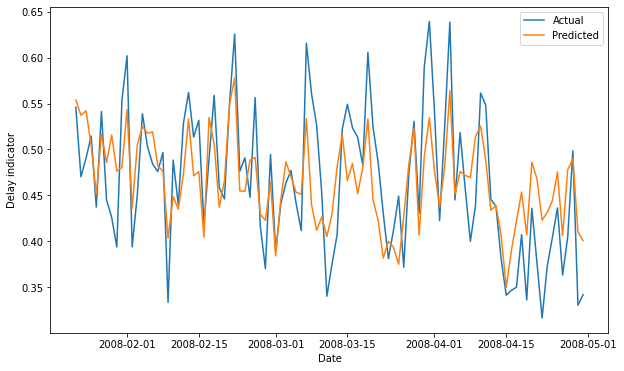

In [32]:
# Plot the actual and predicted values
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_df.index, y_true, label='Actual')
ax.plot(y_pred.index, y_pred, label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Delay indicator')
ax.legend()
plt.show()

In [33]:
# Get a summary of the model
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                 Arr_Delay_boolean   No. Observations:                  751
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                1044.215
Date:                           Wed, 29 Mar 2023   AIC                          -2064.430
Time:                                   07:06:00   BIC                          -2008.973
Sample:                               01-01-2006   HQIC                         -2043.063
                                    - 01-21-2008                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       0.0016      0.001      1.749      0.080      -0.000       0.003
Weather_PC1    -0.0007      0.005     -0